In [64]:
from netgen.occ import *
from ngsolve import *
from netgen.meshing import IdentificationType
#from MS_helper_functions import *
from netgen.webgui import Draw as DrawGeo
from ngsolve.webgui import Draw
Draw = lambda *args, **kwargs : None

import matplotlib.pyplot as plt
%matplotlib widget
plt.ioff()

from myPackage import evalOnLine
from meshGen import mesh2DLaminates


rotated = True
modelHalfAir = True

moartaring=False

onlySmooth = False
onlyRough = False

# class myDraw:
#     scenes = {}
#     def __init__(self, *args, **kwargs):
#         if id(args[0]) not in myDraw.scenes.keys():
#             myDraw.scenes.update({id(args[0]):Draw(*args, **kwargs)})
#         else:
#             myDraw.scenes[id(args[0])].Draw()
#     def updateAll():
#         for s in myDraw.scenes.values():
#             s.Redraw()

In [65]:
lambda1 = 1
lambda2 = 10

order0 = 2

In [66]:
D = 0.04
d = 0.02

ff = 0.7


numSheets = 5

maxh_edges = d/numSheets*1/2 * 0.1


if onlySmooth:
    rotated = False

if onlyRough:
    rotated = True




## 3. All together
### 3.1. Reference Solution 

In [67]:
import importlib

import meshGen as mg
mg = importlib.reload(mg)
mesh2DLaminates = mg.mesh2DLaminates
cMeshRef = mesh2DLaminates(D, d, ff, numSheets, multiscale=False, maxh_edges=[maxh_edges, maxh_edges], fullProblemX=True, onlySmooth = onlySmooth, onlyRough = onlyRough, rotated=rotated, modelHalfAir=modelHalfAir, quad_dominated=False)
meshRef = cMeshRef.mesh
print("Boundaries", set(meshRef.GetBoundaries()))
print("Materials", set(meshRef.GetMaterials()))


maxh_edges [0.0002, 0.0002]
Boundaries {'top', 'default', 'iright', 'ibottom', 'bottom', 'left', 'ileft', 'right', 'itop'}
Materials {'insulation', 'inner', 'outer'}


In [68]:
Draw(meshRef)

In [69]:
lam = meshRef.MaterialCF({"inner":lambda2, "outer":lambda1, "insulation":lambda1, "gap":lambda1, "multiscale":lambda2})
def calcRef():
    fes = H1(meshRef, order=order0, dirichlet="left|right")

    u,v = fes.TnT()
    sol = GridFunction(fes)

    a = BilinearForm(fes, symmetric=True)
    f = LinearForm(fes)

    a += lam * grad(u) * grad(v) * dx

    prec = Preconditioner(a, "direct")


    sol.Set(1 * x/Norm(x), BND)
    solvers.BVP(bf = a, lf= f, pre=prec, gf=sol, maxsteps=10)
    
    
    energy =  Integrate( InnerProduct(lam * grad(sol), grad(sol)), meshRef, definedon=meshRef.Materials("inner|insulation"))
    
    return sol, energy

sol_ref, energy_ref = calcRef()

H_ref = -grad(sol_ref)
B_ref = lam  * H_ref


CG iteration 1, residual = 4.19968404914895     
CG iteration 2, residual = 2.995970292021443e-14     


In [70]:


print(f"energy:\t{energy_ref}")
print(sol_ref)
Draw(sol_ref, settings={"Objects":{"Wireframe":True}, "deformation": 0.01})
Draw( H_ref, meshRef, settings={"Objects":{"Wireframe":False}, "deformation": False}, max = 200)
Draw(B_ref, meshRef, settings={"Objects":{"Wireframe":False}, "deformation": False}, max=400)


energy:	0.7348411348727617
gridfunction 'gfu' on space 'H1HighOrderFESpace(h1ho)'
nested = 0
autoupdate = 0



### 3.2 Multiscale 

In [71]:
import cempy as cp
mg = importlib.reload(mg)
mesh2DLaminates = mg.mesh2DLaminates
cMeshMS = mesh2DLaminates(D, d, ff, numSheets, multiscale=True, modelHalfAir=False, onlySmooth=onlySmooth, onlyRough=onlyRough, 
    domainNameHalfAir="halfAir", maxh_edges= (maxh_edges, maxh_edges), rotated=rotated, modelGap=True)
# cMeshMS = mesh2DLaminates(D, d, ff, numSheets, multiscale=True, modelHalfAir=modelHalfAir, domainNameHalfAir="smoothFrame", onlySmooth=onlySmooth)
meshMS = cMeshMS.mesh
print(meshMS.GetMaterials())
print(set(meshMS.GetBoundaries()))


maxh_edges (0.0002, 0.0002)
('outer', 'outer', 'multiscale', 'gap', 'gap')
{'top', 'iright', 'ibottom', 'bottom', 'left', 'ileft', 'right', 'itop'}


In [72]:

# from ngsolve.webgui import Draw
Draw(CF([1, 2, 3, 4, 5, 6]), meshMS)
from myPackage import drawBndAll

# drawBndAll(meshMS, drawFunc=Draw, block=False)

In [73]:
import importlib
import MS_helper_functions as ms
ms = importlib.reload(ms)
cl_Phi = ms.cl_Phi

getIntegrand4BFI = ms.getIntegrand4BFI
cl_gradgradMS = ms.cl_gradgradMS
pyLobatto = ms.pyLobatto
pydxLobatto = ms.pydxLobatto
getPhiPhiValue = ms.getPhiPhiValue
pyPhiFunction = ms.pyPhiFunction
pyPhiConst = ms.pyPhiConst
pyPhiZero = ms.pyPhiZero



cl_Phi.numSheets = numSheets
cl_Phi.dFe = cMeshMS.dFe
cl_Phi.d0 = cMeshMS.d0
cl_Phi.mesh = meshMS

cl_Phi.modelHalfAir = True
cl_Phi.orientation = 1 if rotated else 0

if False:
    import cempy as cp
    importlib.reload(cp)
    
    
    cl_Phi.phiFunction = cp.phiFunctions.Lobatto
    cl_Phi.dzPhiFunction = cp.phiFunctions.dxLobatto
else:
    cl_Phi.phiFunction = pyLobatto
    cl_Phi.dzPhiFunction = pydxLobatto



In [74]:
force_full_Phi = True


smoothB_fun_Fe = lambda x: 1e3 * lambda1/lambda2 * (x**2/cl_Phi.dFe * 1 - (cl_Phi.dFe/4 * 1))
smoothB_fun_0 = lambda x: 1e3*(-(x - (cl_Phi.d0/2+cl_Phi.dFe/2))**2/ cl_Phi.d0 * 1 + cl_Phi.d0/4 * 1)



smoothH_fun_Fe = lambda x: 1e3 * (x**2/cl_Phi.dFe * 1 - (cl_Phi.dFe/4 * 1))
smoothH_fun_0 = lambda x: 1e3*(-(x - (cl_Phi.d0/2+cl_Phi.dFe/2))**2/ cl_Phi.d0 * 1 + cl_Phi.d0/4 * 1)

smoothBPhi2 = pyPhiFunction(cl_Phi.getZStart(), cl_Phi.getD(), 
    [smoothB_fun_Fe, smoothB_fun_0], numSheets, ff, cl_Phi.orientation, name = "smoothBPhi2", order="smB2", modelHalfAir=False)

smoothHPhi2 = pyPhiFunction(cl_Phi.getZStart(), cl_Phi.getD(), 
    [smoothH_fun_Fe, smoothH_fun_0], numSheets, ff, cl_Phi.orientation, name = "smoothHPhi2", order="smH2", modelHalfAir=False)

smoothPhi2_Fe = pyPhiFunction(cl_Phi.getZStart(), cl_Phi.getD(), 
    [smoothB_fun_Fe, smoothB_fun_0], numSheets, ff, cl_Phi.orientation, name = "smoothPhi2", order="sm2", modelHalfAir=False, inAir=False)
    
def calcMultiscale(useGradients=True, drawPhis=True):
    domains = "multiscale|gap"
    if onlySmooth:
        domains = "multiscale"

    roughbnd = "left|right" if rotated else "top|bottom"
    smoothbnd = "itop|ibottom" if rotated else "ileft|iright"

    if onlySmooth:
        roughbnd = ""

    print("moartaring", moartaring)
    print("modelHalfAir", modelHalfAir)
    print("domains", domains)
    print("roughbnd", roughbnd)
    print("smoothbnd", smoothbnd)

    # microshape functions

    

    orderPhi = [
            cl_Phi([pyPhiConst(), pyPhiZero()], fes_order=order0, material=domains, dirichlet=roughbnd, useGradients=True, useAbsolutes=False),  
            cl_Phi(1, fes_order=order0, material=domains , dirichlet=roughbnd, useGradients=True, useAbsolutes=True, modelHalfAir=True), 
            # cl_Phi(1, fes_order=2, material=domains, dirichlet=roughbnd, useGradients=True, 
            #         specialFirstLast=True, 
            #         specialFirstLast_func=[lambda x : 1/cl_Phi.dFe*(x+cl_Phi.dFe/2), lambda x:1/cl_Phi.dFe*(x-cl_Phi.dFe/2)], 
            #         specialFirstLast_dzfunc=[lambda x : 1/cl_Phi.dFe, lambda x : 1/cl_Phi.dFe], 
            #         ), 


            cl_Phi([smoothBPhi2, smoothBPhi2.getDiff()], fes_order=order0, material=domains, dirichlet=roughbnd, useGradients=True, modelHalfAir=False),
            # cl_Phi([smoothHPhi2, smoothHPhi2.getDiff()], fes_order=order0, material=domains, dirichlet=roughbnd, useGradients=True, modelHalfAir=False),
                        
            # cl_Phi([smoothPhi2_Fe, smoothPhi2_Fe.getDiff()], fes_order=order0, material=domains, dirichlet=roughbnd, useGradients=True, modelHalfAir=False),

            # cl_Phi(2, fes_order=order0, material=domains, dirichlet=roughbnd, inAir=False, useGradients=True, modelHalfAir=False), 
            cl_Phi(2, fes_order=order0, material=domains, dirichlet=roughbnd, inIron=False, modelHalfAir=False), 


            # cl_Phi(4, fes_order=1, material=domains, dirichlet=roughbnd, useGradients=True, inAir=False, modelHalfAir=False), 
            # cl_Phi(4, fes_order=1, material=domains, dirichlet=roughbnd, useGradients=True, inIron=False, modelHalfAir=False), 
        ]

    if not moartaring:
        orderPhi = orderPhi[1:]

    if drawPhis:
        cl_Phi.plotEvaluated(orderPhi, nFig=1)

    VSpace = []
    # # u0 
    domains_outer = "outer"
    if not moartaring:
        domains_outer += "|" + domains 
    VSpace.append(H1(meshMS, order=order0, dirichlet="left|right", definedon=meshMS.Materials(domains_outer))) 
        
    # ui * phi i
    for phi_i in orderPhi: 
        VSpace.append(H1(meshMS, order=phi_i.fes_oder, definedon=meshMS.Materials(phi_i.material), dirichlet=phi_i.dirichlet))
    VSpace = FESpace(VSpace)


    # multiscale container
    ansatz = ""
    sol = GridFunction(VSpace, "sol")
       

    gradgradMS = cl_gradgradMS(orderPhi, sol, addPhi0Outer=True, secondOrder=False)
    gradgradMS.generateCouplingMatrix(lambda2, lambda1, force_full_Phi=force_full_Phi)


    if moartaring:
        slice_inner = slice(1, len(gradgradMS.gradu_pack))
    else:
        slice_inner = slice(0, len(gradgradMS.gradu_pack))


    a = BilinearForm(VSpace, symmetric=False)
    f = LinearForm(VSpace)

    a += lambda1  * grad(gradgradMS.trials[0]) * grad(gradgradMS.tests[0]) * dx("outer")
    a += gradgradMS.getIntegrand4BFI(gradgradMS.gradu_pack[slice_inner], gradgradMS.gradv_pack[slice_inner], lambda1, lambda1, force_full_Phi=force_full_Phi) * dx("gap")
    a += gradgradMS.getIntegrand4BFI(gradgradMS.gradu_pack[slice_inner], gradgradMS.gradv_pack[slice_inner], lambda2, lambda1, force_full_Phi=force_full_Phi) * dx("multiscale")
    
    # a += getIntegrand4BFI(gradgradMS.gradu_pack, gradgradMS.gradv, lambda1, lambda1, force_full_Phi=False, modelHalfAir=False, force_num_int=True) * dx("gap")



    alpha = 3.5
    h = specialcf.mesh_size

    u_start = 1 if moartaring else 0
    # alpha = 1e6
    d_coupling = -d/2 if modelHalfAir else -d/2 + cl_Phi.d0/2


    # absolutes
    u_range = range(u_start, len(gradgradMS.u_pack))
    # u_range = list(range(2, len(gradgradMS.u_pack)))
    # u_range = [0] + u_range

    # u_range = [u_start]
    um_bottom = sum(gradgradMS.u_pack[i][0] * gradgradMS.u_pack[i][1].DirectEvaluate(-d_coupling) for i in u_range)
    vm_bottom = sum(gradgradMS.v_pack[i][0] * gradgradMS.v_pack[i][1].DirectEvaluate(-d_coupling) for i in u_range)

    um_top = sum(gradgradMS.u_pack[i][0] * gradgradMS.u_pack[i][1].DirectEvaluate(d_coupling) for i in u_range)
    vm_top = sum(gradgradMS.v_pack[i][0] * gradgradMS.v_pack[i][1].DirectEvaluate(d_coupling) for i in u_range)

    jump_u_top = gradgradMS.u_pack[0][0] - um_top
    jump_u_bottom = gradgradMS.u_pack[0][0] - um_bottom

    jump_v_top = gradgradMS.v_pack[0][0] - vm_top
    jump_v_bottom = gradgradMS.v_pack[0][0] - vm_bottom

    # gradients
    grad_range = range(u_start, len(gradgradMS.gradu_pack))
    # grad_range = list(range(3, len(gradgradMS.gradu_pack)))
    # grad_range = [1]
    
    gradum_bottom = sum(gradgradMS.gradu_trace_n_pack[i][0] * gradgradMS.gradu_trace_n_pack[i][1].DirectEvaluate(-d_coupling) for i in grad_range)
    gradvm_bottom = sum(gradgradMS.gradv_trace_n_pack[i][0] * gradgradMS.gradv_trace_n_pack[i][1].DirectEvaluate(-d_coupling) for i in grad_range)

    gradum_top = sum(gradgradMS.gradu_trace_n_pack[i][0] * gradgradMS.gradu_trace_n_pack[i][1].DirectEvaluate(d_coupling) for i in grad_range)
    gradvm_top = sum(gradgradMS.gradv_trace_n_pack[i][0] * gradgradMS.gradv_trace_n_pack[i][1].DirectEvaluate(d_coupling) for i in grad_range)

    lambda_inner = lambda1 if modelHalfAir else lambda2

    jump_Bu_top = lambda1 * gradgradMS.gradu_trace_n_pack[0][0] - lambda_inner * gradum_top
    jump_Bu_bottom = lambda1 * gradgradMS.gradu_trace_n_pack[0][0] - lambda_inner * gradvm_bottom

    jump_Bv_top = lambda1 * gradgradMS.gradv_trace_n_pack[0][0] - lambda_inner * gradvm_top
    jump_Bv_bottom = lambda1 * gradgradMS.gradv_trace_n_pack[0][0] - lambda_inner * gradvm_bottom

    # couple u
    if False:
        #[u][v]
        # a += alpha*order0**2/h  * gradgradMS.getIntegrand4BFI(gradgradMS.u_pack[u_start:], gradgradMS.v_pack[u_start:],  1, 1, force_full_Phi=force_full_Phi)  *ds(smoothbnd)
        # a += -alpha*order0**2/h  * gradgradMS.getIntegrand4BFI(gradgradMS.u_pack[u_start:], gradgradMS.v_pack[:1],  1, 1, force_full_Phi=force_full_Phi)  *ds(smoothbnd)
        # a += alpha*order0**2/h  * gradgradMS.getIntegrand4BFI(gradgradMS.u_pack[:1], gradgradMS.v_pack[:1],  1, 1, force_full_Phi=force_full_Phi)  *ds(smoothbnd)
        # a += -alpha*order0**2/h  * gradgradMS.getIntegrand4BFI(gradgradMS.u_pack[:1], gradgradMS.v_pack[u_start:],  1, 1, force_full_Phi=force_full_Phi)  *ds(smoothbnd)

        a += alpha*order0**2/h  * (jump_u_top)  * (jump_v_top)  *ds("itop")
        a += alpha*order0**2/h  * (jump_u_bottom)  * (jump_v_bottom)  *ds("ibottom")
        

    if False:
        #{dn u } [ v]
        a += -gradgradMS.getIntegrand4BFI(gradgradMS.gradu_trace_n_pack[u_start:], gradgradMS.v_pack[u_start:],  lambda2, lambda1, force_full_Phi=force_full_Phi)  *ds(smoothbnd)
        a += gradgradMS.getIntegrand4BFI(gradgradMS.gradu_trace_n_pack[u_start:], gradgradMS.v_pack[:1],  lambda2, lambda1, force_full_Phi=force_full_Phi)  *ds(smoothbnd)
        a += gradgradMS.getIntegrand4BFI(gradgradMS.gradu_trace_n_pack[:1], gradgradMS.v_pack[u_start:],  lambda2, lambda1, force_full_Phi=force_full_Phi)  *ds(smoothbnd)
        a += -gradgradMS.getIntegrand4BFI(gradgradMS.gradu_trace_n_pack[:1], gradgradMS.v_pack[:1],  lambda2, lambda1, force_full_Phi=force_full_Phi)  *ds(smoothbnd)
        # a += (lambda_inner * jump_Bu_top)  * (jump_v_top)  *ds("itop")
        # a += (lambda_inner * jump_Bu_bottom)  * (jump_v_bottom)  *ds("ibottom")


        #[ u] {dn v } 
        a += -gradgradMS.getIntegrand4BFI(gradgradMS.u_pack[u_start:], gradgradMS.gradv_trace_n[u_start:],  lambda2, lambda1, force_full_Phi=force_full_Phi)  *ds(smoothbnd)
        a += gradgradMS.getIntegrand4BFI(gradgradMS.u_pack[u_start:], gradgradMS.gradv_trace_n[:1],  lambda2, lambda1, force_full_Phi=force_full_Phi)  *ds(smoothbnd)
        a += gradgradMS.getIntegrand4BFI(gradgradMS.u_pack[:1], gradgradMS.gradv_trace_n[u_start:],  lambda2, lambda1, force_full_Phi=force_full_Phi)  *ds(smoothbnd)
        a += -gradgradMS.getIntegrand4BFI(gradgradMS.u_pack[:1], gradgradMS.gradv_trace_n[:1],  lambda2, lambda1, force_full_Phi=force_full_Phi)  *ds(smoothbnd)
        # a += (lambda_inner * jump_Bv_top)  * (jump_u_top)  *ds("itop")
        # a += (lambda_inner * jump_Bv_bottom)  * (jump_u_bottom)  *ds("ibottom")

    # couple fluxes
    if False:
        # [dn u] [ dn v]

        alpha = 1e6
        a += alpha*order0**2/h  * gradgradMS.getIntegrand4BFI(gradgradMS.gradu_trace_n_pack[u_start:], gradgradMS.gradv_trace_n_pack[u_start:],  lambda2, lambda1, force_full_Phi=force_full_Phi)  *ds(smoothbnd)
        a += -alpha*order0**2/h  * gradgradMS.getIntegrand4BFI(gradgradMS.gradu_trace_n_pack[u_start:], gradgradMS.gradv_trace_n_pack[:1],  lambda2, lambda1, force_full_Phi=force_full_Phi)  *ds(smoothbnd)
        a += alpha*order0**2/h  * gradgradMS.getIntegrand4BFI(gradgradMS.gradu_trace_n_pack[:1], gradgradMS.gradv_trace_n_pack[:1],  lambda2, lambda1, force_full_Phi=force_full_Phi)  *ds(smoothbnd)
        a += -alpha*order0**2/h  * gradgradMS.getIntegrand4BFI(gradgradMS.gradu_trace_n_pack[:1], gradgradMS.gradv_trace_n_pack[u_start:],  lambda2, lambda1, force_full_Phi=force_full_Phi)  *ds(smoothbnd)

        # alpha = 2
        # a += alpha*order0**2/h  * (jump_Bu_top)  * (jump_Bv_top)  *ds("itop")
        # a += alpha*order0**2/h  * (jump_Bu_bottom)  * (jump_Bv_bottom)  *ds("ibottom")


    # couple hesse 
    if False:

        #{gradgrad(u)_n_n } [ dn v]
        a += -gradgradMS.getIntegrand4BFI(gradgradMS.hesse_u_trace_nn, gradgradMS.gradv_trace_n,  lambda2, lambda1, force_full_Phi=force_full_Phi)  *ds(smoothbnd)
        a += gradgradMS.getIntegrand4BFI(gradgradMS.hesse_u_trace_nn, [gradgradMS.gradv_trace_n[0]],  lambda2, lambda1, force_full_Phi=force_full_Phi)  *ds(smoothbnd)
        a += gradgradMS.getIntegrand4BFI([gradgradMS.hesse_u_trace_nn[0]], gradgradMS.gradv_trace_n,  lambda2, lambda1, force_full_Phi=force_full_Phi)  *ds(smoothbnd)
        a += -gradgradMS.getIntegrand4BFI([gradgradMS.hesse_u_trace_nn[0]], [gradgradMS.gradv_trace_n[0]],  lambda2, lambda1, force_full_Phi=force_full_Phi)  *ds(smoothbnd)


        #[ dn u] {gradgrad(v)_n_n } 
        a += -gradgradMS.getIntegrand4BFI(gradgradMS.gradu_trace_n_pack, gradgradMS.hesse_v_trace_nn,  lambda2, lambda1, force_full_Phi=force_full_Phi)  *ds(smoothbnd)
        a += gradgradMS.getIntegrand4BFI([gradgradMS.gradu_trace_n_pack[0]], gradgradMS.hesse_v_trace_nn,  lambda2, lambda1, force_full_Phi=force_full_Phi)  *ds(smoothbnd)
        a += gradgradMS.getIntegrand4BFI(gradgradMS.gradu_trace_n, [gradgradMS.hesse_v_trace_nn[0]],  lambda2, lambda1, force_full_Phi=force_full_Phi)  *ds(smoothbnd)
        a += -gradgradMS.getIntegrand4BFI([gradgradMS.gradu_trace_n[0]], [gradgradMS.hesse_v_trace_nn[0]],  lambda2, lambda1, force_full_Phi=force_full_Phi)  *ds(smoothbnd)

    prec = Preconditioner(a,type="direct")  


    # dirichlet boundary values
    sol.components[0].Set(1 * x/Norm(x), BND)
    if moartaring:
        sol.components[1].Set(1 * x/Norm(x), BND)
    
    solvers.BVP(bf = a, lf= f, pre=prec, gf=sol, maxsteps=30, tol = 1e-20)

    energy =  Integrate(getIntegrand4BFI(gradgradMS.gradsol_pack, gradgradMS.gradsol_pack, lambda2, lambda1), meshMS, 
                                                    definedon=meshMS.Materials("multiscale"))
    
    print("a norm", a.mat.AsVector().Norm())
    return sol, gradgradMS.sol_pack, gradgradMS.sol_comp, gradgradMS.gradsol_comp, energy, gradgradMS

    






In [75]:
sol_MS, sol_pack_MS, sol_comp_MS, H_comp, energy_MS, gradgradMS = calcMultiscale(False, drawPhis=False)
H_MS = sum(H_comp)
H_MS.Compile()
print("Norm soll diff", Integrate((sum(sol_comp_MS) - sol_ref)* (sum(sol_comp_MS) - sol_ref)/( (sol_ref)**2) , meshRef)*100,  "%")
print("diff energy", energy_MS, energy_ref, energy_MS - energy_ref, (energy_MS - energy_ref)/energy_ref * 100, "%")

# print(Integrate(Norm(sum(sol_comp_MS) - sol_ref), meshRef))


u_MS = sum(sol_comp_MS)

In [45]:
gradgradMS.generateCouplingMatrix(lambda2, lambda1, force_full_Phi=force_full_Phi)
gradgradMS.printCouplingMatrix();
gradgradMS.checkCouplingMatrxiSymmetric(1e-3)

                        0              1               2             3              4            5                   6
--  ------------------  -------------  --------------  ------------  -------------  -----------  ------------------  ----------------
                        pyPhiConstant  pydxLobatto(1)  pyLobatto(1)  dxsmoothBPhi2  smoothBPhi2  pydxLobatto(2)_ins  pyLobatto(2)_ins
0   pyPhiConstant       7.3            4500.0          0.0           -0.0           -0.279       0.0                 -0.098
1   pydxLobatto(1)      4500.0         4404761.905     0.0           0.0            -313.333     -0.0                163.299
2   pyLobatto(1)        0.0            0.0             2.433         313.333        0.0          -163.299            0.0
3   dxsmoothBPhi2       -0.0           0.0             313.333       103333.333     -0.0         -163299.316         0.0
4   smoothBPhi2         -0.279         -313.333        0.0           -0.0           0.03         -0.0                -0.02

In [46]:

gradgradMS.generateGradGradMatrix()
gradgradMS.printGradGradMatrix();

                      dx_v_pyPhiConstant    dy_v_pyPhiConstant             v_1    dx_v_1      dy_v_1    v_dxsmoothBPhi2    dx_v_smB2     dy_v_smB2      v_2_ins    dx_v_2_ins    dy_v_2_ins
------------------  --------------------  --------------------  --------------  --------  ----------  -----------------  -----------  ------------  -----------  ------------  ------------
dx_u_pyPhiConstant             7.3                   0             0             0           0                    0       -0.278667      0                0        -0.0979796     0
dy_u_pyPhiConstant             0                     7.3        4500             0           0                   -0        0            -0.278667         0         0            -0.0979796
u_1                            0                  4500             4.40476e+06   0           0                    0        0          -313.333           -0         0           163.299
dx_u_1                         0                     0             0    

In [47]:
dFe = cMeshMS.dFe
d0 = cMeshMS.d0

assert cMeshMS.dFe == cl_Phi.dFe
assert cMeshMS.d0 == cl_Phi.d0

print((lambda2 * dFe * numSheets + d0 * lambda1 * (numSheets-1))/(dFe*numSheets+d0*(numSheets-1)))
print((lambda2 * dFe * numSheets + d0 * lambda1 * numSheets)/(dFe*numSheets+d0*numSheets))
print((lambda2 * dFe * numSheets  + d0 * lambda1 * (numSheets-1))/(dFe*numSheets+d0*numSheets))


7.702127659574469
7.300000000000001
7.24


In [48]:
print(f"energy MS :\t{energy_MS}, energy ref \t{energy_ref}")
print(meshMS.GetBoundaries())
Draw(u_MS, meshRef, settings={"Objects":{"Wireframe":True}, "deformation": 0.01}, deformation=False)
# Draw( Norm(H_MS), meshRef, settings={"Objects":{"Wireframe":False}, "deformation": False}, max = 200)
# Draw( lam * Norm(H_MS), meshRef, settings={"Objects":{"Wireframe":False}, "deformation": False}, max=400)

energy MS :	0.5814888954165183, energy ref 	0.6978346941504596
('bottom', 'left', 'ibottom_outer', 'ibottom_outer', 'ibottom_outer', 'right', 'itop_outer', 'itop_outer', 'itop_outer', 'left', 'top', 'right', 'iright', 'itop', 'ileft', 'iright', 'itop', 'ileft', 'iright', 'ileft', 'right', 'left')


WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {'Objects': {'Wireframe': Tru…

BaseWebGuiScene

### 1.3 Comparison 

sol components 4


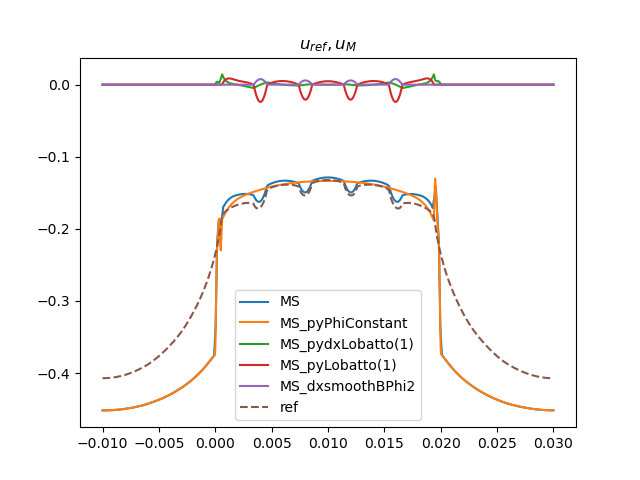

In [50]:

start = -D/2*1.01
end = -D/2*0.9

start = -d/2
end = d/2


plt.figure(2)
start = -D/2
end = D/2

pnt1 = [-d/2*0.99, start, 0] if rotated else [start, -d/2*0.99, 0]
pnt2 = [-d/2*0.99, end, 0] if rotated else [end, -d/2*0.99, 0]


print("sol components", len(sol_comp_MS))
evalOnLine(u_MS , meshRef, pnt1, pnt2, plot=True, ls='-', marker="", clear=True, label="MS", show=False, N=300, x_start_fig=-d/2);
# evalOnLine(sol_comp_MS[0] + sol_comp_MS[1] , meshRef, pnt1, pnt2, plot=True, ls='-', marker="", clear=True, label="MS", show=False, N=300);
[evalOnLine((sol_comp_MS[i]) , meshRef, pnt1, pnt2, plot=True, ls='-', marker="", clear=False, label="MS_" + gradgradMS.gradsol_pack[i][1].name, show=False, N=1000, x_start_fig=-d/2) for i in range(len(sol_comp_MS))];

# evalOnLine((sol_comp_MS[0]) , meshRef, pnt1, pnt2, plot=True, ls='-', marker="x", clear=False, label="MS", show=False, N=300);
# evalOnLine((sol_comp_MS[1]) , meshRef, pnt1, pnt2, plot=True, ls='-', marker="x", clear=False, label="MS", show=False, N=300);
# evalOnLine((sol_comp_MS[2]) , meshRef, pnt1, pnt2, plot=True, ls='-', marker="x", clear=False, label="MS", show=False, N=300);
evalOnLine(sol_ref , meshRef, pnt1, pnt2, plot=True, ls='--', marker="", show=False, clear=False, label="ref", N = 300, title=r"$u_{ref}, u_{M}$", x_start_fig=-d/2);


plt.legend()
plt.show()

In [18]:
# from ngsolve.webgui import Draw
scene1 = Draw(H_MS[0] ,meshRef, settings={"Objects":{"Wireframe":False}})

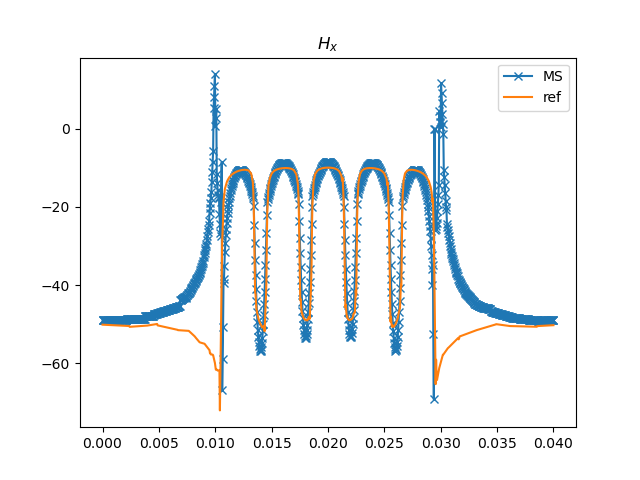

In [19]:
start = -d/2
end = d/2

plt.figure(3)
evalOnLine(H_MS[0] , meshRef, pnt1, pnt2, plot=True, ls='-', marker="x", clear=True, label="MS", show=False, N=1000);
evalOnLine(-grad(sol_ref)[0] , meshRef, pnt1, pnt2, plot=True, ls='-', marker="", show=False, clear=False, label="ref", N = 1000, title=r"$H_x$");



plt.legend()
plt.show()

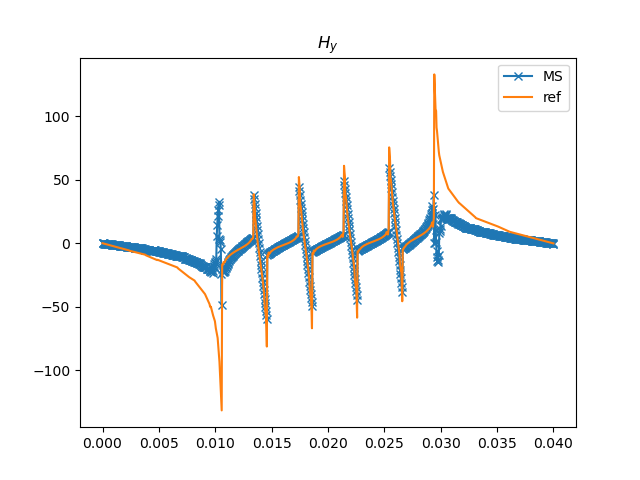

In [20]:
start = -d/2
end = d/2


plt.figure(4)

evalOnLine(H_MS[1] , meshRef, pnt1, pnt2, plot=True, ls='-', marker="x", clear=True, label="MS", show=False, N=1000);
# [evalOnLine((H_comp[i])[1] , meshRef, pnt1, pnt2, plot=True, ls='-', marker="x", clear=False, label="MS_" + gradgradMS.gradsol_pack[i][1].name, show=False, N=1000) for i in range(len(H_comp))];

evalOnLine(-grad(sol_ref)[1] , meshRef, pnt1, pnt2, plot=True, ls='-', marker="", show=False, clear=False, label="ref", N = 1000, title=r"$H_y$");
plt.legend()
plt.show()

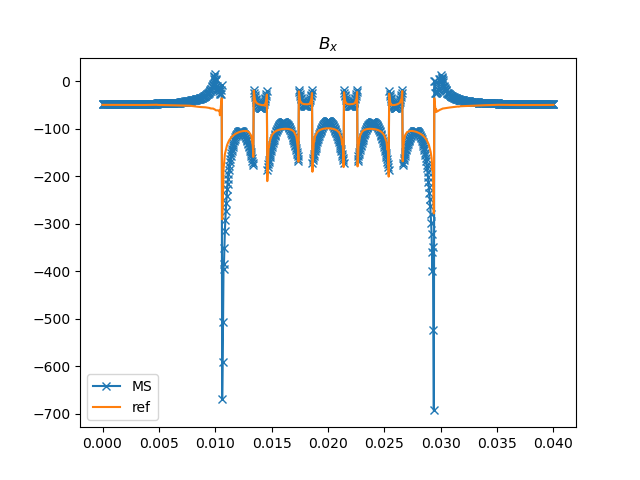

In [21]:
start = -d/2
end = d/2


plt.figure(5)
evalOnLine(lam * H_MS[0] , meshRef, pnt1, pnt2, plot=True, ls='-', marker="x", clear=True, label="MS", show=False, N=1000);
# evalOnLine(lam * (H_comp[0])[0] , meshRef, pnt1, pnt2, plot=True, ls='-', marker="x", clear=False, label="MS", show=False, N=1000);
evalOnLine(-lam * grad(sol_ref)[0] , meshRef, pnt1, pnt2, plot=True, ls='-', marker="", show=False, clear=False, label="ref", N = 1000, title=r"$B_x$");

plt.legend()
plt.show()

pyPhiConstant
pydxLobatto(1)
pyLobatto(1)
dxsmoothBPhi2
smoothBPhi2
pydxLobatto(2)_ins
pyLobatto(2)_ins


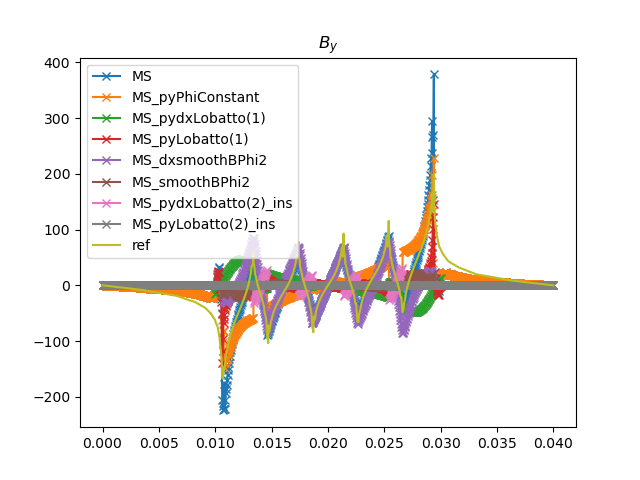

In [22]:
start = -d/2
end = d/2

[print(o[1].name) for o in gradgradMS.gradsol_pack]

plt.figure(6)
evalOnLine(lam * sum(H_comp)[1] , meshRef, pnt1, pnt2, plot=True, ls='-', marker="x", clear=True, label="MS", show=False, N=1000);

[evalOnLine(lam * (H_comp[i])[1] , meshRef, pnt1, pnt2, plot=True, ls='-', marker="x", clear=False, label="MS_" + gradgradMS.gradsol_pack[i][1].name, show=False, N=1000) for i in range(len(H_comp))];

evalOnLine(-lam * grad(sol_ref)[1] , meshRef, pnt1, pnt2, plot=True, ls='-', marker="", show=False, clear=False, label="ref", N = 1000, title=r"$B_y$");

plt.legend()
plt.show()

### Drawings

In [23]:
from ngsolve.webgui import Draw

In [24]:
print(f"energy:\t{energy_MS}", energy_ref)
Draw(IfPos(y, sol_ref, sum(sol_comp_MS)), meshRef, settings={"Objects":{"Wireframe":False}, "deformation": False})


energy:	0.5828370043693605 0.6978346941504596


WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {'Objects': {'Wireframe': Fal…

BaseWebGuiScene

In [25]:
Draw(IfPos(y, -grad(sol_ref), H_MS)[1], meshRef, settings={"Objects":{"Wireframe":False}, "deformation": False}, max=50, min = -50)
Draw(IfPos(y, -grad(sol_ref), H_MS)[0], meshRef, settings={"Objects":{"Wireframe":False}, "deformation": False}, max=50, min = -50)

WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {'Objects': {'Wireframe': Fal…

WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {'Objects': {'Wireframe': Fal…

BaseWebGuiScene

In [26]:
Draw(lam * IfPos(y, -grad(sol_ref), H_MS)[0], meshRef, settings={"Objects":{"Wireframe":False}, "deformation": False},min = -200, max=200)
Draw(lam * IfPos(y, -grad(sol_ref), H_MS )[1], meshRef, settings={"Objects":{"Wireframe":False}, "deformation": False},min = -200, max=200)
lamMS = IfPos(cl_Phi(0, 0, inIron=False, material="multiscale").phi, lambda1, lambda2)

# Draw(lamMS * IfPos(y, -grad(sol_ref), H_MS)[0], meshMS, settings={"Objects":{"Wireframe":False}, "deformation": False},min = -200, max=200)
# Draw(lamMS * IfPos(y, -grad(sol_ref), H_MS)[1], meshMS, settings={"Objects":{"Wireframe":False}, "deformation": False},min = -20, max=20)

WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {'Objects': {'Wireframe': Fal…

WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {'Objects': {'Wireframe': Fal…

In [27]:
print("Norm soll diff", Integrate((sum(sol_comp_MS) - sol_ref)* (sum(sol_comp_MS) - sol_ref)/( (sol_ref)**2) , meshRef)*100,  "%")
print("diff energy", energy_MS, energy_ref, energy_MS - energy_ref, (energy_MS - energy_ref)/energy_ref * 100, "%")



Norm soll diff 0.07694086137278537 %
diff energy 0.5828370043693605 0.6978346941504596 -0.11499768978109914 -16.47921645986615 %


In [28]:
"""
from ngsolve.webgui import Draw
settings={"Objects":{"Wireframe":False}, "deformation": False}
order = 2

mask = meshRef.MaterialCF({"outer":0}, default=1)
Draw(mask * IfPos(x, cl_Phi(order, 0, phiFunction=pyLobatto, dzPhiFunction=pydxLobatto).phi.getDiff(), 
                cl_Phi(order, 0, phiFunction=cp.phiFunctions.Lobatto, dzPhiFunction=cp.phiFunctions.dxLobatto).dzphi), meshRef, 
                settings = settings)

for order in [0, 1, 2, 3, 4]:
    print(order, Integrate(cl_Phi(order, 0, phiFunction=pyLobatto, dzPhiFunction=pydxLobatto).phi- \
                cl_Phi(order, 0, phiFunction=cp.phiFunctions.Lobatto, dzPhiFunction=cp.phiFunctions.dxLobatto).phi, meshRef, definedon=meshRef.Materials("insulation|inner")))
    print(order, "_Fe", Integrate(cl_Phi(order, 0, phiFunction=pyLobatto, dzPhiFunction=pydxLobatto, inAir=False).phi- \
                cl_Phi(order, 0, phiFunction=cp.phiFunctions.Lobatto, dzPhiFunction=cp.phiFunctions.dxLobatto, inAir=False).phi, meshRef, definedon=meshRef.Materials("insulation|inner")))
    print(order, "_0", Integrate(cl_Phi(order, 0, phiFunction=pyLobatto, dzPhiFunction=pydxLobatto, inIron=False).dzphi- \
                cl_Phi(order, 0, phiFunction=cp.phiFunctions.Lobatto, dzPhiFunction=cp.phiFunctions.dxLobatto, inIron=False).dzphi, meshRef, definedon=meshRef.Materials("insulation|inner")))
    
    print(order, "dz", Integrate(cl_Phi(order, 0, phiFunction=pyLobatto, dzPhiFunction=pydxLobatto).dzphi- \
                cl_Phi(order, 0, phiFunction=cp.phiFunctions.Lobatto, dzPhiFunction=cp.phiFunctions.dxLobatto).dzphi, meshRef, definedon=meshRef.Materials("insulation|inner")))

    print(order, "dz_Fe", Integrate(cl_Phi(order, 0, phiFunction=pyLobatto, dzPhiFunction=pydxLobatto, inAir=False).dzphi- \
                cl_Phi(order, 0, phiFunction=cp.phiFunctions.Lobatto, dzPhiFunction=cp.phiFunctions.dxLobatto, inAir=False).dzphi, meshRef, definedon=meshRef.Materials("insulation|inner")))
    print(order, "dz_0", Integrate(cl_Phi(order, 0, phiFunction=pyLobatto, dzPhiFunction=pydxLobatto, inIron=False).dzphi- \
                cl_Phi(order, 0, phiFunction=cp.phiFunctions.Lobatto, dzPhiFunction=cp.phiFunctions.dxLobatto, inIron=False).dzphi, meshRef, definedon=meshRef.Materials("insulation|inner")))

    print("=============0")
"""

'\nfrom ngsolve.webgui import Draw\nsettings={"Objects":{"Wireframe":False}, "deformation": False}\norder = 2\n\nmask = meshRef.MaterialCF({"outer":0}, default=1)\nDraw(mask * IfPos(x, cl_Phi(order, 0, phiFunction=pyLobatto, dzPhiFunction=pydxLobatto).phi.getDiff(), \n                cl_Phi(order, 0, phiFunction=cp.phiFunctions.Lobatto, dzPhiFunction=cp.phiFunctions.dxLobatto).dzphi), meshRef, \n                settings = settings)\n\nfor order in [0, 1, 2, 3, 4]:\n    print(order, Integrate(cl_Phi(order, 0, phiFunction=pyLobatto, dzPhiFunction=pydxLobatto).phi-                 cl_Phi(order, 0, phiFunction=cp.phiFunctions.Lobatto, dzPhiFunction=cp.phiFunctions.dxLobatto).phi, meshRef, definedon=meshRef.Materials("insulation|inner")))\n    print(order, "_Fe", Integrate(cl_Phi(order, 0, phiFunction=pyLobatto, dzPhiFunction=pydxLobatto, inAir=False).phi-                 cl_Phi(order, 0, phiFunction=cp.phiFunctions.Lobatto, dzPhiFunction=cp.phiFunctions.dxLobatto, inAir=False).phi, meshRef